In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from IPython.display import HTML
import time
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision import models
import torchvision.datasets as datasets
import numpy as np
import torchvision.utils as utils
import torch.nn.functional as F
from scipy import linalg
import matplotlib.pyplot as plt

In [2]:
dataset = datasets.CIFAR10(root="/home/sandyap/data", download=False,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=32,
                                         shuffle=True, num_workers=2)

device = torch.device("cuda")

In [5]:
real_img_list = []

for batch_idx, (data, _) in enumerate(dataloader):
    if batch_idx == 0:
        # Take the first batch of data as an example
        real_images = data.detach().cpu()
        real_img_list.append(utils.make_grid(real_images, padding=2, normalize=True))

# The list real_img_list should now contain the grid of real images


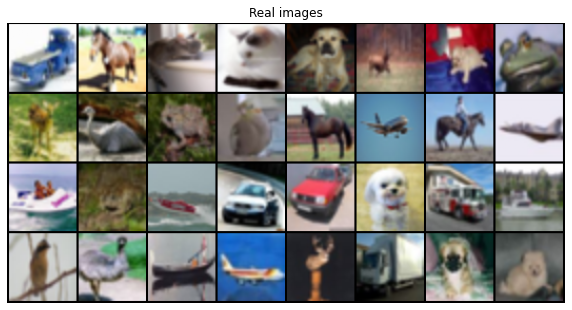

In [6]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Real images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [7]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

In [8]:
class Generator(nn.Module):    
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

In [9]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [10]:
lr = 2e-4
Z_DIM = 128
num_epochs = 15
WEIGHT_CLIP = 0.01

In [11]:
gen = Generator(Z_DIM, channels_img = 3, features_g = 64).to(device)
critic = Discriminator(channels_img = 3, features_d = 64).to(device)
initialize_weights(gen)
initialize_weights(critic)

In [12]:
opt_gen = optim.RMSprop(gen.parameters(), lr = lr)
opt_critic = optim.RMSprop(critic.parameters(), lr = lr)

fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
step = 0

gen.train()
critic.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
  )
)

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
GenLoss2 = []
DiscLoss2 = []
img_list2 = []
real_list=[]
iters = 0
fd=[]

for epoch in range(num_epochs):
    # Target labels not needed! <3 unsupervised
    epoch=epoch+1
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        cur_batch_size = data.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)]
        for _ in range(5): # 5 critic iterations
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise)
            critic_real = critic(data).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

            # clip critic weights between -0.01, 0.01
            for p in critic.parameters():
                p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP)

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
        # Print losses occasionally
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(dataloader)} \
                  Loss Discriminator: {loss_critic:.3f}, loss Generator: {loss_gen:.3f}"
            )
        #saving the losses for every 100 batch
        GenLoss2.append(loss_gen.detach().cpu())
        DiscLoss2.append(loss_critic.detach().cpu())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs) and (batch_idx == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            img_list2.append(utils.make_grid(fake, padding=2, normalize=True)) 
            #real_images = data.detach().cpu()
            real_list.append(utils.make_grid(data, padding=2, normalize=True))
        iters += 1
    

Epoch [1/15] Batch 0/1563                   Loss Discriminator: -0.066, loss Generator: 0.035
Epoch [1/15] Batch 100/1563                   Loss Discriminator: -1.418, loss Generator: 0.715
Epoch [1/15] Batch 200/1563                   Loss Discriminator: -1.406, loss Generator: 0.698
Epoch [1/15] Batch 300/1563                   Loss Discriminator: -1.405, loss Generator: 0.702
Epoch [1/15] Batch 400/1563                   Loss Discriminator: -1.320, loss Generator: 0.666
Epoch [1/15] Batch 500/1563                   Loss Discriminator: -1.161, loss Generator: 0.676
Epoch [1/15] Batch 600/1563                   Loss Discriminator: -1.188, loss Generator: 0.647
Epoch [1/15] Batch 700/1563                   Loss Discriminator: -1.149, loss Generator: 0.656
Epoch [1/15] Batch 800/1563                   Loss Discriminator: -1.034, loss Generator: 0.564
Epoch [1/15] Batch 900/1563                   Loss Discriminator: -0.967, loss Generator: 0.442
Epoch [1/15] Batch 1000/1563              

In [15]:
# now using........
import math
def IS(img_list, model, num_splits=10, normalize=True):
    scores = []
    softmax = F.softmax(img_list, dim=1)
    split_scores = []
    for i in range(num_splits):
        #print('debug2')
        fraction = softmax.size(0) // num_splits
        #print(fraction)
        #print(fraction)
        split = softmax[i * fraction : (i + 1) * fraction, :]
        #print('split')
        #print(split)
        kl = split * (torch.log(split) - torch.log(torch.mean(split, dim=0, keepdim=True)))
        kl = kl.sum(dim=1)
        score_i = torch.exp(torch.mean(kl))
        split_scores.append(score_i)
            #print(split_scores)
    scores.append(torch.mean(torch.stack(split_scores)))
    # Compute the final score
    score = torch.mean(torch.stack(scores))
    if normalize:
        score /= math.exp(1)
    return score.item()


In [16]:
def extract_features(img_list, model):
    model.eval()
    img_features_list = []
    for img_batch in img_list:
        img_batch = img_batch.to(device)
        img_features = model(img_batch)[0]
        if img_features.ndim < 2:
            img_features = img_features.unsqueeze(0)
        img_features = F.adaptive_avg_pool2d(img_features, output_size=1)
        img_features = img_features.view(img_features.size(0), -1)
        img_features_list.append(img_features)
    return torch.cat(img_features_list, dim=0)

In [17]:
#from torchmetrics.image.inception import InceptionScore
from torchvision.models import inception_v3
inception_model = inception_v3(pretrained=True, transform_input=False).to(device).eval()

In [18]:
img_sq = [img.unsqueeze(0) for img in img_list2]
features = extract_features(img_sq, inception_model)
score = IS(features, inception_model)
#IS(img_list,inception_model,32)
score

0.3678794503211975

In [19]:
act1=np.empty((len(real_list), 2048))

mu1 = np.mean(act1, axis=0)

sigma1 = np.cov(act1, rowvar=False)

act2=np.empty((len(img_list2), 2048))

sigma2 = np.cov(act2, rowvar=False)

mu2 = np.mean(act2, axis=0)

mu1 = np.atleast_1d(mu1)
mu2 = np.atleast_1d(mu2)

sigma1 = np.atleast_2d(sigma1)
sigma2 = np.atleast_2d(sigma2)
fid=calculate_frechet_distance(mu1, sigma1, mu2, sigma2)
print(fid)

In [ ]:
from scipy.spatial.distance import cdist

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    # calculate sqrt of product of covariances
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # calculate the FID score using Nearest Neighbor approximation
    mu1 = mu1.reshape(1, -1)
    mu2 = mu2.reshape(1, -1)
    m = cdist(mu1, mu2, metric='euclidean')
    s = np.trace(sigma1) + np.trace(sigma2) - 2 * np.trace(covmean)
    return m[0, 0] + s


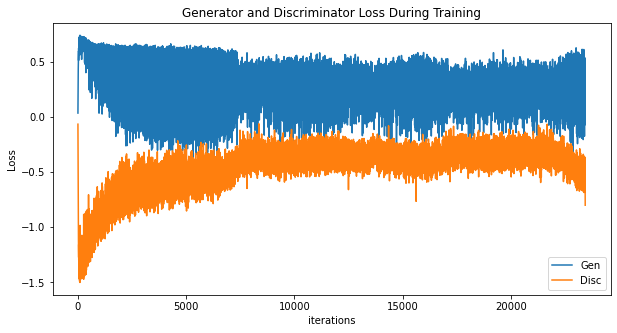

In [19]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(GenLoss2,label="Gen")
plt.plot(DiscLoss2,label="Disc")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

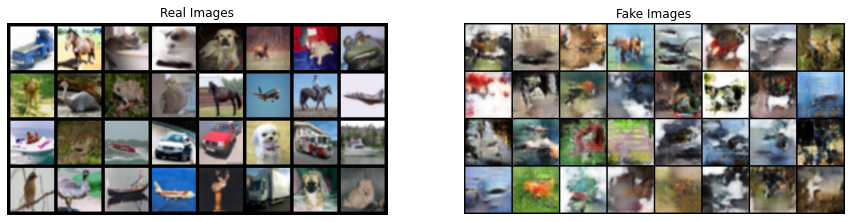

In [21]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list2[-1],(1,2,0)))
plt.savefig('compare.png')
plt.show()